#### Bibliotécas utilizadas

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.ndimage import gaussian_filter, convolve

#### Carregamento e preparação das imagens

In [9]:
build_image1 = cv2.imread('Imagens//building1.jpg',0)/255  # Carrega, converte para grayscale e normaliza os pixels(0.0-1.0)
build_image2 = cv2.imread('Imagens//building2.jpg',0)/255
goi_image1   = imread('Imagens//goi1.jpg')/255             # Carrega e normaliza os pixels(0.0-1.0)
goi_image2   = imread('Imagens//goi2.jpg')/255

#### Detector de cantos de Harris

In [12]:
def harris_corners_detector(img, k, wc, wh, tr):
    
    image         = cv2.GaussianBlur(img, (9, 9), 2.5) # Aplica um filtro Gaussiano na imagem para deixa-la mais suave e reduzir o efeito das bordas
    rows, columns = np.shape(image)                    # Obtém o tamanho da imagem
    pad_wc        = wc // 2                            # Padding da janela Wc em torno do seu centro
    pad_wh        = wh // 2                            # Padding da janela Wh em torno do seu centro
    keypoints     = []                                 # Armazena os keypoints
    
    # Operador de Sobel em x
    Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])
    
    # Operador de Sobel em y
    Sy = Sx.T
    
    Ix = np.zeros(image.shape) # Armazena as derivadas no eixo x
    Iy = np.zeros(image.shape) # Armazena as derivadas no eixo y
    R  = np.zeros(image.shape) # Armazena os valores dos calculos dos operadores de Harris
  
    # Convolui a imagem com os operadores de Sobel calculando a derivada para cada pixel da imagem(Janela do operador de Sobel com dimensão 3(Wd=3))
    Ix = convolve(image, Sx)
    Iy = convolve(image, Sy)
    
    # Operações elemento a elemento nas matrizes com as derivadas, obtém os termos para composição da matriz de Covariância
    Ixx = Ix**2 #(A)
    Ixy = Ix*Iy #(B)
    Iyy = Iy**2 #(C)
    
    # Convolui a matriz por kernels de 1's com tamanha window_size, acumulando a soma de todos os elementos dentro das janelas de tamanho window_size
    # nas variáveis correspondentes.
    kernel  = np.ones((wc, wc))
    sum_Ixx = convolve(Ixx, kernel)
    sum_Ixy = convolve(Ixy, kernel)
    sum_Iyy = convolve(Iyy, kernel)
    
    # Cálcula o operador de Harris sem precisar calcular a matriz de covarância e seus autovalores
    R = (sum_Ixx * sum_Iyy - sum_Ixy**2) - k * (sum_Ixx + sum_Iyy)**2
    
    # Percorre a matriz com os valores dos operadores de Harris e define os keypoints como os máximos locais que são
    # maiores que o threshold, isto elimina keypoints desnecessários restando apenas os que melhor representam suas regiões.
    for i in range(pad_wh, rows - pad_wh):
        for j in range(pad_wh, columns - pad_wh):
            window = R[i - pad_wh:i + pad_wh + 1, j - pad_wh:j + pad_wh + 1]
            if R[i, j] == np.max(window) and R[i, j] > tr:
                keypoints.append([i, j])
                
    return keypoints

#### Cálculo dos keypoints 

#### Imagens building


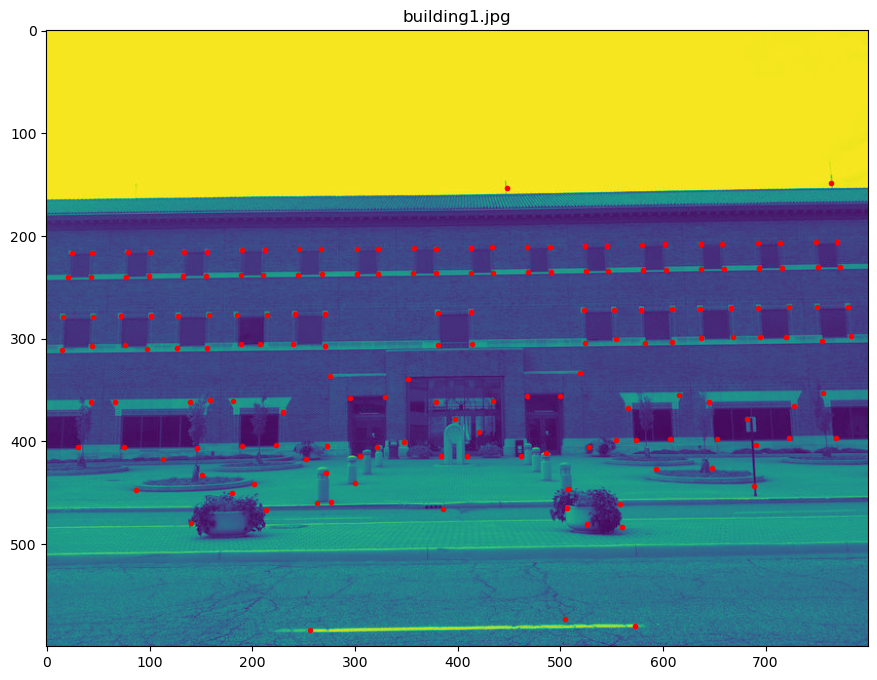

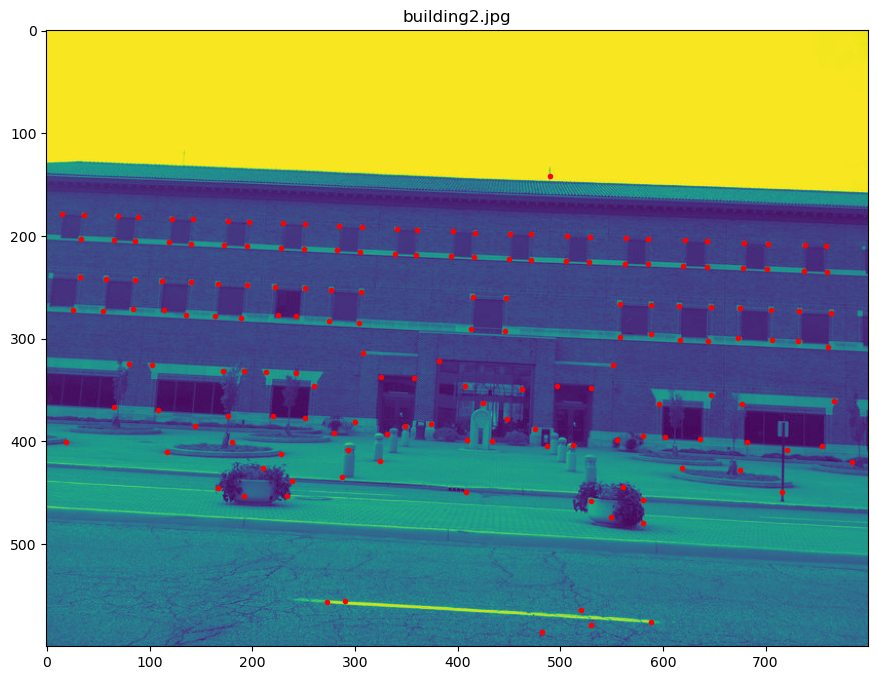

In [16]:
k                  = 0.04
window_size        = 7
window_size_max    = 27
threshold          = 0.050
corner_list_build1 = harris_corners_detector(build_image1, k, window_size, window_size_max, threshold)
corner_list_build2 = harris_corners_detector(build_image2, k, window_size, window_size_max, threshold)

plt.figure(figsize=(12, 8))
for k in range(len(corner_list_build1)):
    plt.plot(corner_list_build1[k][1], corner_list_build1[k][0], marker='.', color="red")
plt.title('building1.jpg')
plt.imshow(build_image1)
plt.show()

plt.figure(figsize=(12, 8))
for k in range(len(corner_list_build2)):
    plt.plot(corner_list_build2[k][1], corner_list_build2[k][0], marker='.', color="red")
plt.title('building2.jpg')
plt.imshow(build_image2)
plt.show()

#### Imagens goi

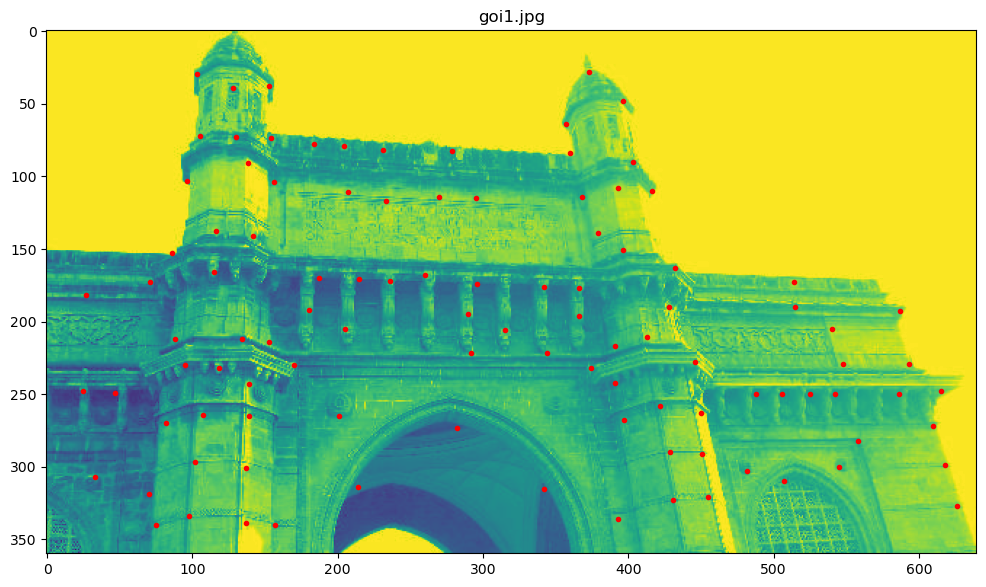

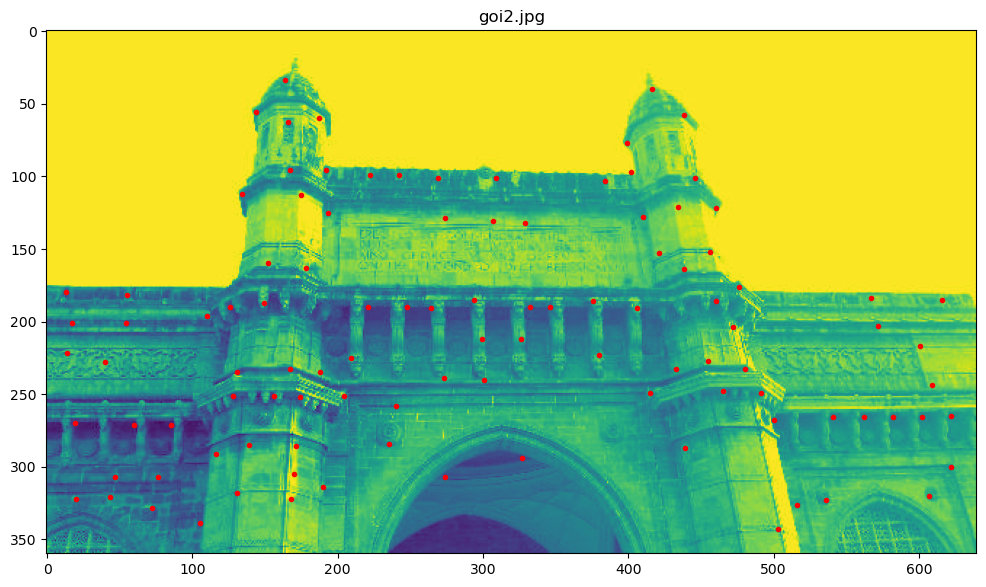

In [18]:
k                 = 0.04
window_size       = 7
window_size_max   = 27
threshold         = 0.025
corner_list_goi1  = harris_corners_detector(goi_image1, k, window_size, window_size_max, threshold)
corner_list_goi2  = harris_corners_detector(goi_image2, k, window_size, window_size_max, threshold)

plt.figure(figsize=(12, 8))
for k in range(len(corner_list_goi1)):
    plt.plot(corner_list_goi1[k][1], corner_list_goi1[k][0], marker='.', color="red")
plt.title('goi1.jpg')
plt.imshow(goi_image1)
plt.show()

plt.figure(figsize=(12, 8))
for k in range(len(corner_list_goi2)):
    plt.plot(corner_list_goi2[k][1], corner_list_goi2[k][0], marker='.', color="red")
plt.title('goi2.jpg')
plt.imshow(goi_image2)
plt.show()

##### Ao aplicar a suavização da imagem com filtros gaussianos, o algoritmo conseguiu reduzir os efeitos indesejados das bordas. Além disso, a filtragem dos keypoints pelos máximos locais eliminou keypoints redundantes, garantindo uma seleção mais precisa. Como resultado, os pontos extraídos representaram melhor as características relevantes das imagens, proporcionando uma boa quantidade de correspondências entre suas diferentes versões. Cabe ressaltar que foi possível calcular o operador R de uma forma mais eficiente obtendo seu valor direto dos termos gerados das derivadas, dispensando a construção da matriz C e o cálculo de seus autovalores. Depois de ajustar os parâmetos manualmente, os valores que apresentaram os melhores resultados foram:
<p style="text-align: center;">𝑊𝐻 = 27</p>
<p style="text-align: center;">𝑇𝑅 = 0.025</p>

##### Com 𝑊𝐷 = 3 e 𝑊𝐶 = 7

### Função para o casamento de características

In [21]:
def find_matches(img1, img2, keypoints1, keypoints2, w_ssd, t_ssd, trazao_ssd):

    keypts1 = keypoints1.copy()  # Cria uma cópia dos conjuntos de keypoints
    keypts2 = keypoints2.copy()
    matches = []                 # Armazena os casamentos
    half_w  = w_ssd // 2         # Padding da janela escolhida 

    # Percorre os keypoints da primeira imagem
    for i in range(len(keypts1)):
        x1,y1 = keypts1[i]       # Obtém as coordenadas dos keypoint da primeira imagem
        
        best_match     = None    # Variáveis para rastrear o melhor match e o segundo melhor match
        second_best    = None
        best_index     = None;
        min_ssd        = np.inf
        second_min_ssd = np.inf

        # Verifica se a janela do keypoint esta dentro dos limites da primeira imagem 
        if x1 < half_w or x1 >= img1.shape[0] - half_w or y1 < half_w or y1 >= img1.shape[1] - half_w:
            continue

        # Janela do keypoint da primeira imagem
        window1 = img1[x1 - half_w:x1 + half_w + 1, y1 - half_w:y1 + half_w + 1] 

        # Percorre os keypoints da segunda imagem
        for j in range(len(keypts2)):
            x2,y2 = keypts2[j]   # Obtém as coordenadas dos keypoint da segunda imagem

            # Verifica se a janela do keypoint esta dentro dos limites da segunda imagem 
            if x2 < half_w or x2 >= img2.shape[0] - half_w or y2 < half_w or y2 >= img2.shape[1] - half_w:
                continue

            # Janela do keypoint da segunda imagem
            window2 = img2[x2 - half_w:x2 + half_w + 1, y2 - half_w:y2 + half_w + 1]

            # Calcula o SSD entre as duas janelas    
            ssd = np.sum((window1 - window2) ** 2)

            # Atualiza o menor ssd e o segundo menor ssd e o melhor match encontrado
            if ssd < min_ssd:
                second_min_ssd = min_ssd
                second_best    = best_match
                min_ssd        = ssd
                best_match     = [x1, y1, x2, y2] 
                best_index     = j
            elif ssd < second_min_ssd:
                second_min_ssd = ssd

        # Verifica se o menor ssd e o segundo menor ssd atendem todos os critérios
        if min_ssd < t_ssd and (min_ssd / (second_min_ssd + 1e-9)) < trazao_ssd:
            matches.append(best_match)  # Adiciona o match
            keypts2.pop(best_index)     # Retira os keypoint utilizados da segunda imagem para que não sejam utilizados novamente.

    return matches

### Função para plotar as imagens

In [23]:
def plot_matches(img1, img2, matches):
    
    composed_image = np.concatenate((img1, img2), axis=1)
    plt.figure(figsize=(12, 12))
    plt.imshow(composed_image)

    for (x1, y1, x2, y2) in matches:
        y2 += img1.shape[1]
        plt.plot([y1, y2], [x1, x2], 'r-',linewidth=0.5)
        plt.plot(y1, x1, marker='.', color="white")
        plt.plot(y2, x2, marker='.', color="white")
    
    plt.axis('off')
    plt.show()

### Casamento dos keypoints das imagens building

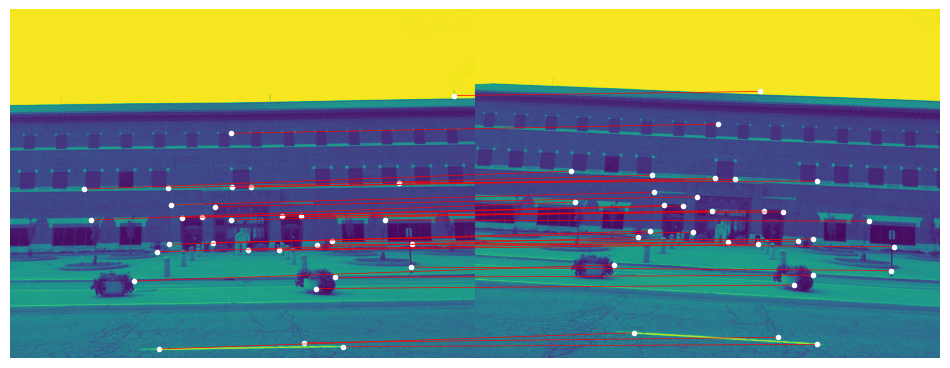

In [51]:
WSSD      = 9
TSSD      = 10
TrazaoSSD = 0.305 

matches_build = find_matches(build_image1, build_image2, corner_list_build1, corner_list_build2, WSSD, TSSD, TrazaoSSD)
plot_matches(build_image1, build_image2, matches_build)

### Casamento dos keypoints das imagens goi

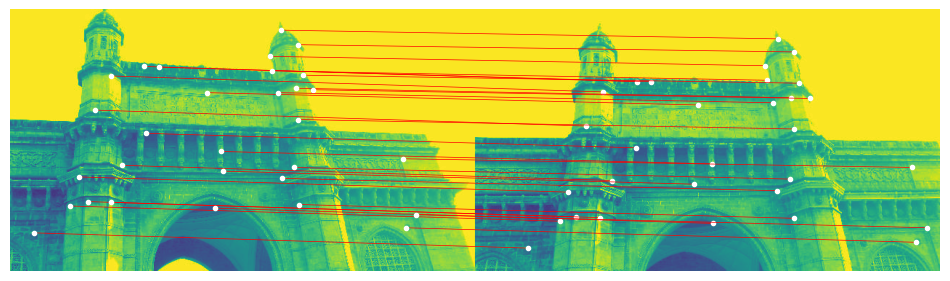

In [27]:
WSSD      = 9
TSSD      = 10
TrazaoSSD = 0.395 

matches_goi = find_matches(goi_image1, goi_image2, corner_list_goi1, corner_list_goi2, WSSD, TSSD, TrazaoSSD)
plot_matches(goi_image1, goi_image2, matches_goi)

##### Ajustando os valores da janela ao redor do ponto caracterísitico $W_{SSD}$ e dos limiares $T_{SSD}$ e $T_{razãoSSD}$ foi possível obter um conjuto com boas correspondências, onde a maioria dos pontos da primeira imagem foi correspondida corretamente com pontos da segunda imagem, como é possível verificar acima. Os valores dos parâmetros que apresentaram melhores resultados foram.

$$ W_{SSD} = 9$$
$$ T_{SSD} = 10$$
$$T_{razãoSSD} = 0.305 \ \ e \ \ 0.395$$